# Energy System Characteristics 

This notebook computes key energy system characteristics (e.g. share of different tech in electricity, PE an so on)

For questions about this notebook, please contact Guarav Ganti <gaurav.ganti@climateanalytics.org>.

In [1]:
import os 
import pyam 
import matplotlib.pyplot as plt 
import numpy as np 
import string
import matplotlib
font = {'size'   : 16}

matplotlib.rc('font', **font)

<IPython.core.display.Javascript object>

# Read in data

In [2]:
institution_data = pyam.IamDataFrame(
    os.path.join(
        '..','data','institutional_scenario_data.xlsx'
    ),
    sheet_name = 'Indicators'
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/institutional_scenario_data.xlsx


In [3]:
sr15_data = pyam.IamDataFrame(
    os.path.join(
        '..','data','sr15_data_extract.xlsx'
    )
)

pyam.core - INFO: Reading file ../data/sr15_data_extract.xlsx
pyam.core - INFO: Reading meta indicators


# Unit handling

In [4]:
institution_data = institution_data.convert_unit(
    'Mtoe/yr', 
    'EJ/yr'
)

In [5]:
institution_data = institution_data.convert_unit(
    'TWh/yr', 
    'EJ/yr'
)

# Aggregate wind and solar

In [6]:
institution_data.aggregate(
    "Secondary Energy|Electricity|WindSolar",
    components = [
        "Secondary Energy|Electricity|Wind",
        "Secondary Energy|Electricity|Solar"
    ],
    append = True
)

In [7]:
sr15_data.aggregate(
    "Secondary Energy|Electricity|WindSolar",
    components = [
        "Secondary Energy|Electricity|Wind",
        "Secondary Energy|Electricity|Solar"
    ],
    append = True
)

# Calculate electricity / FE

In [8]:
# For institutional data
institution_data.divide(
    a = "Final Energy|Electricity", 
    b = "Final Energy", 
    name = "Share of electricity in fe", 
    append = True 
)

In [9]:
# For SR1.5 data
sr15_data.divide( 
    a = "Final Energy|Electricity", 
    b = "Final Energy", 
    name = "Share of electricity in fe", 
    append = True
)

# Calculate shares of tech

In [10]:
vars_for_shares = [
    "WindSolar", "Coal", 
    "Gas", "Nuclear"
]

In [11]:
for var in vars_for_shares:
    var_to_crunch = "Secondary Energy|Electricity|{}".format(var)
    name_to_append = "{} share in electricity".format(var)

    # Crunch share for institutional data
    institution_data.divide(
        var_to_crunch,
        "Secondary Energy|Electricity",
        name_to_append,
        append = True
    )

    # Crunch share for sr15 data
    sr15_data.divide(
        var_to_crunch,
        "Secondary Energy|Electricity",
        name_to_append,
        append = True
    )

# Plotting params

In [12]:
filter_args = dict(
    df = sr15_data, 
    category = ['Below 1.5C','1.5C low overshoot', '1.5C high overshoot', 'Lower 2C', 'Higher 2C', 'Above 2C'],
    join_meta = True
)

In [13]:
rc = {
    'Below 1.5C' : '#7ebbae',
    '1.5C low overshoot' : '#99cfe0',
    '1.5C high overshoot' : '#828eac',
    'Lower 2C' : '#eebdab',
    'Higher 2C' : '#d86c67',
    'Above 2C' : 'grey'
}

In [14]:
marker_categories = [
    ('NZ2021', '^', 'red','IEA (NZE)'),
    ('SDS_2020', '^', 'black', 'IEA (SDS)'),
    ('Net_Zero', '*','red', 'BP (Net Zero)'),
    ('Rapid','*','black', 'BP (Rapid)'),
    ('Sky','s','black', 'Shell (Sky 1.5)'),
    ('Rebalance', '+', 'black', 'Equinor (Rebalance)')
]

In [15]:
def boxplot_of_variable(ax, variable, ylabel, years = [2030,2050],percent=False, legend=False, save=False, save_name=None, type = 'eps'):

    _data = pyam.filter_by_meta(
        sr15_data.filter(variable = variable, region='World').timeseries(),
        **filter_args
    )

    _inst = institution_data.filter(variable = variable)

    groupby = _data.groupby('category')
    plot_cats = [
        'Below 1.5C','1.5C low overshoot', '1.5C high overshoot', 'Lower 2C', 'Higher 2C', 'Above 2C', 'foo'
    ]
    _cats = len(plot_cats) - 1
    w = 0.6 / _cats

    for i, name in enumerate(plot_cats):
        if name not in groupby.groups:
            for scen, marker, color,label in marker_categories:
                try:
                    ax.scatter(x=[], y=[],marker = marker, color=color, s=100, label=label)
                    _scen = _inst.filter(scenario=scen).timeseries()
                    for j, y in enumerate(years):
                        pos = pos = (0.75 / _cats * (i - _cats / 2) + j)
                        try:
                            if percent:
                                _pt = _scen[y].values[0] * 100
                            else:
                                _pt = _scen[y].values[0]
                            ax.scatter(
                                x = pos, y = _pt, s=100, label=None,
                                marker = marker, color=color,alpha=0.5 
                            )
                        except:
                            continue
                except:
                    continue
        else:
            _df = groupby.get_group(name)
            c = rc[name]
            for j, y in enumerate(years):
                if percent:
                    lst = _df[y][~np.isnan(_df[y])]* 100
                else:
                    lst = _df[y][~np.isnan(_df[y])]
                pos = (0.75 / _cats * (i - _cats / 2) + j)
                p = ax.boxplot(lst, positions=[pos], widths=w * .90,
                                        whis=[0,100], sym='',
                                        patch_artist=True)
                ax.tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=True if len([2030, 2050]) > 1 else False
                )
                plt.setp(p['boxes'], color=c)
                plt.setp(p['medians'], color='black')

                if (name == "1.5C low overshoot" and variable in ["Final Energy", "Share of electricity in fe"]):
                    _led_data = sr15_data.filter(
                        scenario = "LowEnergyDemand", 
                        variable = variable, 
                        region = "World"
                    ).timeseries()

                    if percent: 
                        _led_pt = _led_data[y].values[0] * 100 
                    else:
                        _led_pt = _led_data[y].values[0]

                    ax.scatter(
                        x = pos, y = _led_pt, s=100, label = None, 
                        marker = "h", color = "#1f77b4", alpha=1
                    )
                    

            ax.plot([], c=c, label='{} [{}]'.format(name, len(_df)))

        ax.set_xlim(-0.6, (len(years) - 0.4))
        ax.set_xticks(range(0, len(years)))
        ax.set_xticklabels(years)
        if legend:
            ax.legend(ncol=1, bbox_to_anchor = (1.1, 0.8))
       
    ax.grid(alpha=0.3)
    ax.set_ylabel(ylabel)

In [16]:
vars_to_plot = [ 
    "WindSolar share in electricity", 
    "Nuclear share in electricity",     
    "Share of electricity in fe", 
    "Coal share in electricity", 
    "Gas share in electricity", 
    "Final Energy"
]

#vars_to_plot = [
#    '{} share in electricity'.format(x) for x in vars_for_shares
#]
#vars_to_plot.append('Share of electricity in fe')
#vars_to_plot.append('Final Energy')

In [17]:
vars_to_plot

['WindSolar share in electricity',
 'Nuclear share in electricity',
 'Share of electricity in fe',
 'Coal share in electricity',
 'Gas share in electricity',
 'Final Energy']

In [18]:
titles = [
    'Wind and Solar in electricity',
    'Nuclear in electricity',
    'Electricity in total final consumption',    
    'Coal in electricity',    
    'Gas in electricity',
    'Final Energy',
]

pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!
pyam.core - WARNING: Filtered IamDataFrame is empty!


Text(-0.5, 53, 'Low Energy Demand\n(Grubler et al., 2019)')

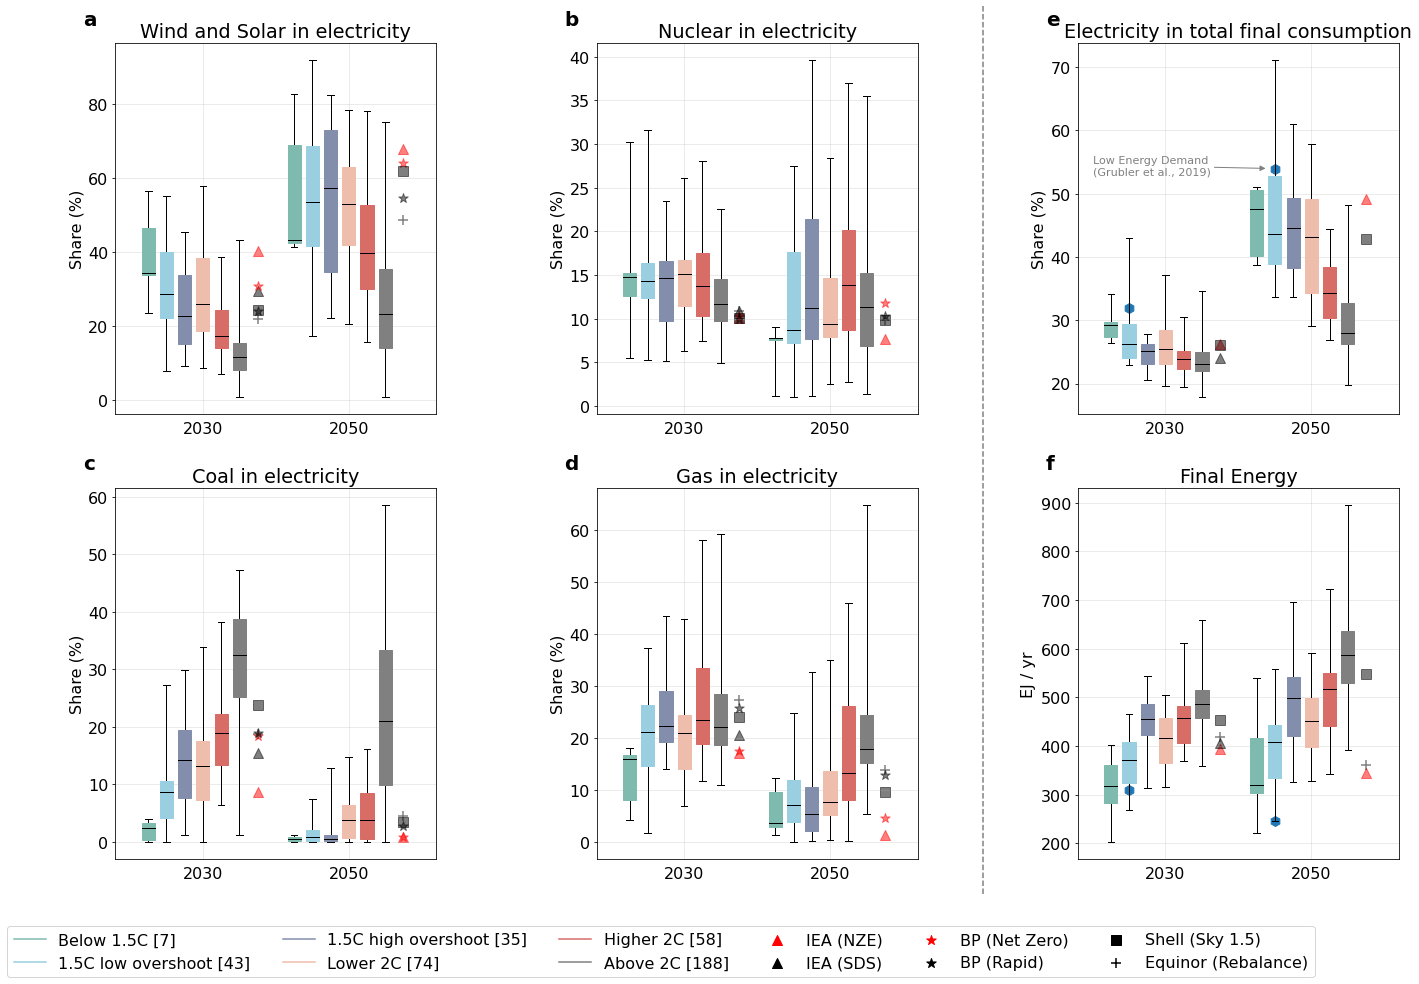

In [19]:
fig, ax = plt.subplots(2,3,figsize=(23,15))

i = j = 0 

ylab = 'Share (%)'
percent = True

for var, title in zip(vars_to_plot, titles):
    if i > 2:
        i = 0
        j = 1
    
    if i > 1 and j == 1:
        ylab = 'EJ / yr'
        percent = False
    
    boxplot_of_variable(
        ax[j,i],
        var,
        ylab,
        legend=False,
        percent = percent
    )

    ax[j,i].set_title(title)

    # Add text annotation 
    if j == 0:
        character_to_add = string.ascii_lowercase[i]
        if character_to_add == "c":
            character_to_add = "e"
        ax[j,i].text(-0.1, 1.05, character_to_add, transform= ax[j,i].transAxes,
        size = 20, weight="bold")
    else:
        character_to_add = string.ascii_lowercase[i+3]
        if character_to_add == "d":
            character_to_add = "c"
        elif character_to_add == "e":
            character_to_add = "d"
        ax[j,i].text(-0.1, 1.05, character_to_add, transform= ax[j,i].transAxes,
        size = 20, weight="bold")

    i += 1

ax[1,0].legend(loc='center', ncol=6, bbox_to_anchor = (1.7, -0.25))
plt.subplots_adjust(wspace=0.5)

trans = ax[0,1].get_xaxis_transform()
ax[0,1].plot([2.05,2.05],[1.1,-1.3], color="k", linestyle="dashed", alpha=0.5, transform=trans, clip_on=False)

# Add an LED annotations to the plot
ax[0,2].annotate(
    'Low Energy Demand\n(Grubler et al., 2019)', 
    fontsize="x-small", 
    color = "grey", 
    xy = (0.7, 54), 
    xytext = (-.5,53), 
    xycoords = "data", 
    textcoords = "data", 
    arrowprops=dict(
        arrowstyle= '-|>',
        color = "grey", 
    )
)

In [20]:
fig.savefig(
    os.path.join('figures', 'fig4_energy_system_multi_panel.png'),
    dpi=600,
    bbox_inches='tight'
)

In [21]:
fig.savefig(
    os.path.join('figures', 'fig4_energy_system_multi_panel.svg'),
    dpi=800,
    bbox_inches='tight'
)